# Matching Code

This code is to implement and test different matching methods

Explain why we did matching? plot average distances of matching. Think of a KPI. Illustrate with one graph or visualisation, this can be a good distance measure, then back up with literature, the ECB article.

Comapre the coverage, do we have more bonds than taking a very strict matching algorithm, Create a table with different matching algorithms and the results. Show that we used different matching methods.

emphasise that the data is scarce, we do not want to lose too much data, get better results with broader scope. 

In [48]:
import pandas as pd

url = "https://raw.githubusercontent.com/Fijiman001/EGR-Empirical-Project/refs/heads/main/data/Final%20data%20for%20the%20study/df_final_7.csv"
df = pd.read_csv(url)
print(df.columns)
print(df.head())

Index(['Name', 'Clean_Company_Maturity', 'WKN', 'URL', 'ISIN', 'Company',
       'Kupon_Maturity', 'Coupon', 'Maturity_Start', 'Maturity_End',
       'is_green', 'Last Price', 'DateTime', 'Volume in Euro', '+/- %',
       'Currency', 'YTM', 'Modified Duration', 'Kupon', 'Emittent', 'Branche',
       'Fälligkeit', 'Schuldnerkündigungsart', 'Sonderkündigung', 'Nachrangig',
       'Kleinste handelbare Einheit', 'Spezialist', 'Handelsmodell',
       'Emissionsdatum', 'Emissionsvolumen', 'Umlaufendes Volumen',
       'Emissionswährung', 'Depotwährung', 'Notierungsaufnahme',
       'Emission_year_2020.0', 'Emission_year_2021.0', 'Emission_year_2022.0',
       'Emission_year_2023.0', 'Emission_year_2024.0', 'Emission_year_2025.0',
       'Date', 'fälligkeit_datum', 'emission_datum', 'days_to_maturity'],
      dtype='object')
                   Name Clean_Company_Maturity     WKN  \
0  E.ON SE 0,375% 20/27    e on se 0 375 20 27  A254QR   
1  E.ON SE 0,375% 20/27    e on se 0 375 20 27  A254QR

In [49]:
# %pip install sklearn
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances

def match_green_bonds(df):
    # Ensure the dataframe has the necessary columns
    required_cols = ['Company', 'DateTime', 'Coupon', 'days_to_maturity', 'Emission_year_2020.0', 
                    'Emission_year_2021.0', 'Emission_year_2022.0', 
                    'Emission_year_2023.0', 'Emission_year_2024.0', 
                    'Emission_year_2025.0', 'is_green', 'SchuldnerkÃ¼ndigungsart']
    
    # Add is_green column if it doesn't exist (for testing)
    if 'is_green' not in df.columns:
        # This is just for testing - you would replace this with your actual data
        df['is_green'] = np.random.choice([0, 1], size=len(df))
    
    # Create features for matching
    features = ['Coupon', 'days_to_maturity']
    
    # Add emission year as a feature
    emission_cols = [col for col in df.columns if col.startswith('Emission_year_')]
    
    # Create a function to convert emission year columns to a single value
    def get_emission_year(row):
        for col in emission_cols:
            if row[col]:
                # Extract year from column name (e.g., 'Emission_year_2020.0' -> 2020)
                return float(col.split('_')[2].split('.')[0])
        return np.nan
    
    df['emission_year'] = df.apply(get_emission_year, axis=1)
    features.append('emission_year')
    
    # Filter out rows with missing values in crucial columns
    df_clean = df.dropna(subset=features + ['Company', 'is_green'])
    
    # Get unique companies
    companies = df_clean['Company'].unique()
    
    # Prepare results dataframe
    results = []
    
    # For each company, match green bonds with conventional bonds
    for company in companies:
        company_bonds = df_clean[df_clean['Company'] == company]
        
        # Skip if there are no green bonds or no conventional bonds
        if 1 not in company_bonds['is_green'].values or 0 not in company_bonds['is_green'].values:
            continue
        
        green_bonds = company_bonds[company_bonds['is_green'] == 1]
        conv_bonds = company_bonds[company_bonds['is_green'] == 0]
        
        # Extract features for matching
        green_features = green_bonds[features].values
        conv_features = conv_bonds[features].values
        
        # Standardize features
        scaler = StandardScaler()
        green_scaled = scaler.fit_transform(green_features)
        conv_scaled = scaler.transform(conv_features)
        
        # Calculate distances between each green bond and each conventional bond
        distances = euclidean_distances(green_scaled, conv_scaled)
        
        # Match each green bond with the closest conventional bond
        for i, green_idx in enumerate(green_bonds.index):
            closest_conv_idx = conv_bonds.index[np.argmin(distances[i])]
            
            # Create a pair
            green_bond = green_bonds.loc[green_idx]
            conv_bond = conv_bonds.loc[closest_conv_idx]
            
            results.append({
                'Company': company,
                'Green_Bond_Name': green_bond['Name'] if 'Name' in green_bond.index else 'Unknown',
                'Green_Bond_ISIN': green_bond['ISIN'] if 'ISIN' in green_bond.index else 'Unknown',
                'Green_Bond_Coupon': green_bond['Coupon'],
                'Green_Bond_Maturity': green_bond['days_to_maturity'],
                'Green_Bond_Emission_Year': green_bond['emission_year'],
                'Green_Bond_DateTime': green_bond['DateTime'],
                'Conv_Bond_Name': conv_bond['Name'] if 'Name' in conv_bond.index else 'Unknown',
                'Conv_Bond_ISIN': conv_bond['ISIN'] if 'ISIN' in conv_bond.index else 'Unknown',
                'Conv_Bond_Coupon': conv_bond['Coupon'],
                'Conv_Bond_Maturity': conv_bond['days_to_maturity'],
                'Conv_Bond_Emission_Year': conv_bond['emission_year'],
                'Conv_Bond_DateTime': conv_bond['DateTime'],
                'Distance': distances[i][np.argmin(distances[i])]
            })
    
    # Create results dataframe
    results_df = pd.DataFrame(results)
    return results_df

matched_bonds = match_green_bonds(df)

In [50]:
matched_bonds

,Company,Green_Bond_Name,Green_Bond_ISIN,Green_Bond_Coupon,Green_Bond_Maturity,Green_Bond_Emission_Year,Green_Bond_DateTime,Conv_Bond_Name,Conv_Bond_ISIN,Conv_Bond_Coupon,Conv_Bond_Maturity,Conv_Bond_Emission_Year,Conv_Bond_DateTime,Distance
0,e on se,"E.ON SE 0,375% 20/27",xs2103014291,0.375,1000.0,2020.0,2025-01-02T08:40:00Z,"E.ON SE 0,75% 20/28",xs2177580250,0.75,1138.0,2020.0,2025-01-08T09:25:00Z,0.299536
1,e on se,"E.ON SE 0,375% 20/27",xs2103014291,0.375,1000.0,2020.0,2025-01-02T10:53:00Z,"E.ON SE 0,75% 20/28",xs2177580250,0.75,1138.0,2020.0,2025-01-08T09:25:00Z,0.299536
2,e on se,"E.ON SE 0,375% 20/27",xs2103014291,0.375,1000.0,2020.0,2025-01-02T13:47:00Z,"E.ON SE 0,75% 20/28",xs2177580250,0.75,1138.0,2020.0,2025-01-08T09:25:00Z,0.299536
3,e on se,"E.ON SE 0,375% 20/27",xs2103014291,0.375,999.0,2020.0,2025-01-03T08:40:00Z,"E.ON SE 0,75% 20/28",xs2177580250,0.75,1138.0,2020.0,2025-01-08T09:25:00Z,0.300163
4,e on se,"E.ON SE 0,375% 20/27",xs2103014291,0.375,999.0,2020.0,2025-01-03T11:30:00Z,"E.ON SE 0,75% 20/28",xs2177580250,0.75,1138.0,2020.0,2025-01-08T09:25:00Z,0.300163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4800,nrw bank,NRW.BANK 3% 23/30,de000nwb0au2,3.000,1978.0,2023.0,2024-12-30T13:03:00Z,"NRW.BANK 2,75% 24/28",de000nwb2ta0,2.75,1134.0,2024.0,2025-01-13T15:04:00Z,2.914387
4801,nrw bank,NRW.BANK 3% 23/30,de000nwb0au2,3.000,1946.0,2023.0,2025-01-31T08:15:00Z,"NRW.BANK 2,75% 24/28",de000nwb2ta0,2.75,1134.0,2024.0,2025-01-13T15:04:00Z,2.812417
4802,nrw bank,NRW.BANK 3% 23/30,de000nwb0au2,3.000,1946.0,2023.0,2025-01-31T14:00:00Z,"NRW.BANK 2,75% 24/28",de000nwb2ta0,2.75,1134.0,2024.0,2025-01-13T15:04:00Z,2.812417
4803,nrw bank,NRW.BANK 3% 23/30,de000nwb0au2,3.000,1946.0,2023.0,2025-01-31T15:00:00Z,"NRW.BANK 2,75% 24/28",de000nwb2ta0,2.75,1134.0,2024.0,2025-01-13T15:04:00Z,2.812417


for any given green bond, take the match which has the smallest distance
take average distance. group by bonds and conventional bond unique name, compute mean average distance.
then take smallest pair in average.

weight the coupon in the distance measure a bit less, put more weight on the days to maturity.
include emission date measure. 

Show this in our analysis.

test YTM vs. Z-spread.

In [51]:
# print(matched_bonds['Green_Bond_ISIN'].nunique()) 100 unique green bond ISINs
# dropping duplicates
matched_bonds.drop_duplicates(inplace=True)
# no longer need other columns other than the ISINS
matched_bonds_ISIN = matched_bonds[['Green_Bond_ISIN', 'Conv_Bond_ISIN', 'Distance', ]]
matched_bonds_ISIN

,Green_Bond_ISIN,Conv_Bond_ISIN,Distance
0,xs2103014291,xs2177580250,0.299536
1,xs2103014291,xs2177580250,0.299536
2,xs2103014291,xs2177580250,0.299536
3,xs2103014291,xs2177580250,0.300163
4,xs2103014291,xs2177580250,0.300163
...,...,...,...
4800,de000nwb0au2,de000nwb2ta0,2.914387
4801,de000nwb0au2,de000nwb2ta0,2.812417
4802,de000nwb0au2,de000nwb2ta0,2.812417
4803,de000nwb0au2,de000nwb2ta0,2.812417


# Using this matching method, we get 100 matches

In [52]:
import pandas as pd
import numpy as np

def prepare_regression_data(matched_bonds, original_df):
    """
    Prepare the regression dataset from matched green and conventional bonds.
    
    Parameters:
    matched_bonds (DataFrame): The matched pairs of green and conventional bonds
    original_df (DataFrame): The original dataset with YTM information
    
    Returns:
    DataFrame: Clean dataset ready for regression analysis
    """
    # Create regression dataset from matched pairs
    regression_data = []
    
    for _, row in matched_bonds.iterrows():
        # Green bond data
        green_data = {
            'ISIN': row['Green_Bond_ISIN'],
            'Company': row['Company'],
            'Coupon': row['Green_Bond_Coupon'],
            'Maturity': row['Green_Bond_Maturity'],
            'Emission_Year': row['Green_Bond_Emission_Year'],
            'is_green': 1,
            'Distance': row['Distance'],
            'Bond_Pair_ID': _  # Use row index as pair identifier
        }
        
        # Conventional bond data
        conv_data = {
            'ISIN': row['Conv_Bond_ISIN'],
            'Company': row['Company'],
            'Coupon': row['Conv_Bond_Coupon'],
            'Maturity': row['Conv_Bond_Maturity'],
            'Emission_Year': row['Conv_Bond_Emission_Year'],
            'is_green': 0,
            'Distance': row['Distance'],
            'Bond_Pair_ID': _  # Same pair identifier
        }
        
        regression_data.append(green_data)
        regression_data.append(conv_data)
    
    # Create dataframe
    reg_df = pd.DataFrame(regression_data)
    
    # Merge with original data to get YTM and DateTime
    reg_df = pd.merge(
        reg_df,
        original_df[['ISIN', 'YTM', 'DateTime']],
        on='ISIN',
        how='left'
    )
    
    # Convert all numeric columns to float
    numeric_cols = ['is_green', 'Coupon', 'Maturity', 'Distance', 'YTM', 'Emission_Year']
    for col in numeric_cols:
        reg_df[col] = pd.to_numeric(reg_df[col], errors='coerce')
    
    # Drop rows with missing values in key columns
    reg_df = reg_df.dropna(subset=['YTM', 'is_green', 'Coupon', 'Maturity', 'Distance'])
    
    # Handle company dummies properly
    # First ensure Company column has proper encoding and clean values
    reg_df['Company'] = reg_df['Company'].astype(str).str.strip()
    
    # Let's print the unique companies to verify
    print(f"Number of unique companies: {reg_df['Company'].nunique()}")
    print(f"Company values: {reg_df['Company'].unique()[:5]}...")  # Show first 5
    
    # Create company dummy variables - ensure they're properly encoded
    company_cols = pd.get_dummies(reg_df['Company'], prefix='Company', drop_first=True)
    
    # Instead of using get_dummies on the entire dataframe, combine manually
    reg_df = pd.concat([reg_df, company_cols], axis=1)
    
    return reg_df

df_regression = prepare_regression_data(matched_bonds, df)

Number of unique companies: 35
Company values: ['e on se' 'landwirtschaftliche rentenbank' 'de volksbank n v'
 'volkswagen international finance n v' 'instituto de credito oficial']...


In [53]:
df_regression

,ISIN,Company,Coupon,Maturity,Emission_Year,is_green,Distance,Bond_Pair_ID,YTM,DateTime,...,Company_nrw bank,Company_power finance corp ltd,Company_prologis international funding ii s a,Company_quebec provinz,Company_raiffeisen bank international ag,Company_rwe ag,Company_ungarn republik,Company_volkswagen international finance n v,Company_volkswagen leasing gmbh,Company_zf finance gmbh
0,xs2103014291,e on se,0.375,1000.0,2020.0,1,0.299536,0,2.46,2025-01-02T08:40:00Z,...,False,False,False,False,False,False,False,False,False,False
1,xs2103014291,e on se,0.375,1000.0,2020.0,1,0.299536,0,2.50,2025-01-02T10:53:00Z,...,False,False,False,False,False,False,False,False,False,False
2,xs2103014291,e on se,0.375,1000.0,2020.0,1,0.299536,0,2.47,2025-01-02T13:47:00Z,...,False,False,False,False,False,False,False,False,False,False
3,xs2103014291,e on se,0.375,1000.0,2020.0,1,0.299536,0,2.51,2025-01-03T08:40:00Z,...,False,False,False,False,False,False,False,False,False,False
4,xs2103014291,e on se,0.375,1000.0,2020.0,1,0.299536,0,2.55,2025-01-03T11:30:00Z,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371522,de000nwb0au2,nrw bank,3.000,1946.0,2023.0,1,2.812417,4804,2.66,2025-01-31T15:00:00Z,...,True,False,False,False,False,False,False,False,False,False
371523,de000nwb0au2,nrw bank,3.000,1946.0,2023.0,1,2.812417,4804,2.62,2025-01-31T16:00:00Z,...,True,False,False,False,False,False,False,False,False,False
371524,de000nwb2ta0,nrw bank,2.750,1134.0,2024.0,0,2.812417,4804,2.51,2025-01-13T15:04:00Z,...,True,False,False,False,False,False,False,False,False,False
371525,de000nwb2ta0,nrw bank,2.750,1134.0,2024.0,0,2.812417,4804,2.67,2025-01-13T16:00:00Z,...,True,False,False,False,False,False,False,False,False,False


In [54]:
import statsmodels.api as sm
from statsmodels.tools import add_constant

# First prepare data
reg_df = prepare_regression_data(matched_bonds, df)

# For regression analysis, select appropriate columns
X_cols = ['is_green', 'Coupon', 'Maturity', 'Distance']
company_cols = [col for col in reg_df.columns if col.startswith('Company_')]

# Combine main variables with company dummies
X = reg_df[X_cols + company_cols]
y = reg_df['YTM']

# Ensure all columns are numeric
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

# Drop rows with any NaN values
X = X.dropna()
y = y.loc[X.index]

# Add constant and run regression
X = add_constant(X)

# Ensure all data is float
X = X.astype(float)
y = y.astype(float)

# Run regression
model = sm.OLS(y, X).fit()

Number of unique companies: 35
Company values: ['e on se' 'landwirtschaftliche rentenbank' 'de volksbank n v'
 'volkswagen international finance n v' 'instituto de credito oficial']...


In [55]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    YTM   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     9028.
Date:                Sat, 15 Mar 2025   Prob (F-statistic):               0.00
Time:                        19:20:42   Log-Likelihood:            -2.6798e+05
No. Observations:              357000   AIC:                         5.360e+05
Df Residuals:                  356961   BIC:                         5.365e+05
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                                                                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

• Aggregate bonds by ISIN per company (since each bond appears over multiple dates) so that matching is done at the bond‐level rather than per DateTime row.
• Compute a custom distance using three features (Coupon, days‐to‐maturity, and an emission year extracted from your emission columns). We then down‐weight Coupon (here by a factor of 0.5) so that differences in days‐to‐maturity and emission year matter more.
• Perform one‐to‐one matching by solving a bipartite assignment (using the Hungarian algorithm via SciPy’s linear_sum_assignment) so that each green bond is matched with one conventional bond (and vice‐versa as far as possible).
• After matching, we merge the matched bond pairs back with the original time‐series data (using DateTime) to compute the YTM difference (green minus conventional) on the dates where both bonds are observed.
• Finally, we run a regression of the YTM difference on the matching “distance” as an example. (You could, of course, include additional controls or test against the Z‑spread if available.)
• A bar chart is produced as a key performance indicator (KPI) visualization of average matching distance per company. This type of plot can serve as a “good distance measure” and can be compared with similar measures in the literature (for example, see the ECB article on matching methods).

Why Matching?
 Matching green bonds with conventional ones allows us to form comparable pairs so that differences in yield‐to‐maturity (YTM) can be more reliably attributed to “green” factors rather than differences in bond characteristics. A good distance measure (here the Euclidean distance between standardized features) helps ensure that the matched pairs are similar. Researchers (see, for example, ECB publications) have used similar approaches to control for confounding variables.

Visualization (KPI):
 The bar chart of average matching distance per company provides an intuitive measure of how “close” the pairs are. A lower average distance indicates better matches. This can be used as a key performance indicator when comparing different matching methods.

Coverage vs. Stringency:
 By comparing the number of matches and average distances across methods (as illustrated in the optional summary table), one can demonstrate that while stricter matching may yield a lower average distance (better quality), it might also lead to a smaller sample. In our context—where data are scarce—a broader matching criterion (one-to-one matching as shown) may be preferable.

Regression Analysis:
 After matching, the code merges the time series data so that for each bond pair we have YTM observations over time. The regression of the YTM difference on the matching distance (and any other covariates you may add) tests whether the “quality” of the match relates to the observed YTM spread. You could extend this analysis to test against the Z‑spread as well.

Stacked Panel Regression:
The new function prepare_stacked_regression_data creates a dataset where each time-series observation from the green and conventional bonds is kept (with an indicator is_green and other characteristics such as Coupon and maturity). We then run a panel regression (using clustered standard errors by bond pair) to see if, after controlling for these factors, there is a significant difference in YTM between green and conventional bonds.

One-to-One Matching - Number of matched pairs: 58
                  Company Green_Bond_ISIN                     Green_Bond_Name  \
0  ab svensk exportkredit    xs2491737461     AB Svensk Exportkredit 2% 22/27   
1   bayerische landesbank    xs2411178630  Bayerische Landesbank 1,375% 21/32   
2           berlin hyp ag    de000bhy0gn0          Berlin Hyp AG 0,375% 22/27   
3           berlin hyp ag    de000bhy0gt7          Berlin Hyp AG 2,875% 23/30   
4           berlin hyp ag    de000bhy0gx9           Berlin Hyp AG 0,01% 20/30   

   Green_Bond_Coupon  Green_Bond_Maturity  Green_Bond_Emission_Year  \
0              2.000                915.0                    2022.0   
1              1.375               2887.0                    2021.0   
2              0.375                759.0                    2022.0   
3              2.875               1978.0                    2023.0   
4              0.010               2075.0                    2020.0   

  Conv_Bond_ISIN                    

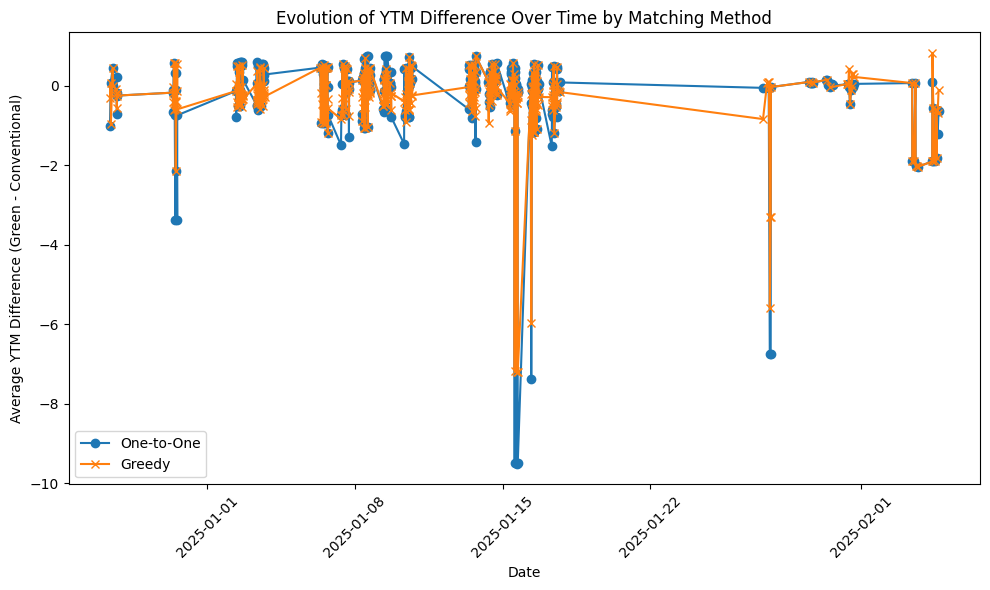

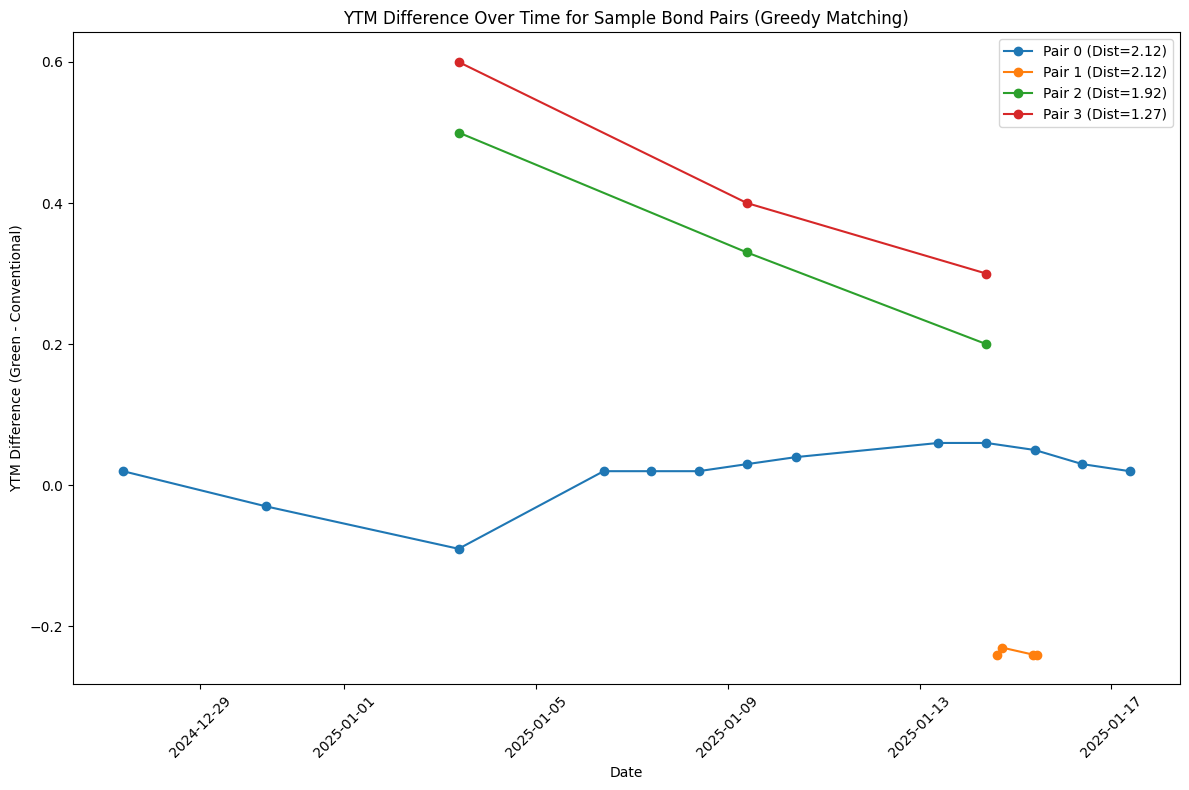

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
import statsmodels.api as sm
import statsmodels.formula.api as smf

# -------------------------------
# Helper Functions
# -------------------------------
def get_emission_year(row, emission_cols):
    """Extract the emission year from the emission year columns."""
    for col in emission_cols:
        if row[col]:
            return float(col.split('_')[2].split('.')[0])
    return np.nan

# -------------------------------
# One-to-One Matching Function
# -------------------------------
def match_green_bonds_one_to_one(df):
    """
    For each company, perform one-to-one matching between green and conventional bonds.
    Matching is based on a Euclidean distance computed from standardized features.
    """
    required_cols = ['Company', 'DateTime', 'Coupon', 'days_to_maturity', 'is_green']
    required_cols += [col for col in df.columns if col.startswith('Emission_year_')]
    
    emission_cols = [col for col in df.columns if col.startswith('Emission_year_')]
    df['emission_year'] = df.apply(lambda row: get_emission_year(row, emission_cols), axis=1)
    
    # Use first observation per bond (grouped by Company and ISIN)
    df_unique = df.sort_values('DateTime').groupby(['Company', 'ISIN']).first().reset_index()
    companies = df_unique['Company'].unique()
    results = []
    
    for company in companies:
        comp_df = df_unique[df_unique['Company'] == company]
        if not (1 in comp_df['is_green'].values and 0 in comp_df['is_green'].values):
            continue
        
        green_df = comp_df[comp_df['is_green'] == 1].copy().reset_index(drop=True)
        conv_df = comp_df[comp_df['is_green'] == 0].copy().reset_index(drop=True)
        
        features = ['Coupon', 'days_to_maturity', 'emission_year']
        combined = comp_df[features]
        means = combined.mean()
        stds = combined.std()
        green_scaled = ((green_df[features] - means) / stds).reset_index(drop=True)
        conv_scaled = ((conv_df[features] - means) / stds).reset_index(drop=True)
        
        # Down-weight coupon differences
        coupon_weight = 0.5
        green_scaled['Coupon'] *= coupon_weight
        conv_scaled['Coupon'] *= coupon_weight
        
        green_mat = green_scaled.values
        conv_mat = conv_scaled.values
        dist_matrix = np.sqrt(((green_mat[:, None, :] - conv_mat[None, :, :]) ** 2).sum(axis=2))
        
        row_ind, col_ind = linear_sum_assignment(dist_matrix)
        for r, c in zip(row_ind, col_ind):
            green_row = green_df.iloc[r]
            conv_row = conv_df.iloc[c]
            results.append({
                'Company': company,
                'Green_Bond_ISIN': green_row['ISIN'],
                'Green_Bond_Name': green_row.get('Name', 'Unknown'),
                'Green_Bond_Coupon': green_row['Coupon'],
                'Green_Bond_Maturity': green_row['days_to_maturity'],
                'Green_Bond_Emission_Year': green_row['emission_year'],
                'Conv_Bond_ISIN': conv_row['ISIN'],
                'Conv_Bond_Name': conv_row.get('Name', 'Unknown'),
                'Conv_Bond_Coupon': conv_row['Coupon'],
                'Conv_Bond_Maturity': conv_row['days_to_maturity'],
                'Conv_Bond_Emission_Year': conv_row['emission_year'],
                'Distance': dist_matrix[r, c]
            })
    return pd.DataFrame(results)

# -------------------------------
# Greedy Matching Function (Many-to-One)
# -------------------------------
def match_green_bonds_greedy(df):
    """
    For each company, perform greedy matching (each green bond gets matched to its closest
    conventional bond, even if the latter is used more than once).
    """
    required_cols = ['Company', 'DateTime', 'Coupon', 'days_to_maturity', 'is_green']
    required_cols += [col for col in df.columns if col.startswith('Emission_year_')]
    
    emission_cols = [col for col in df.columns if col.startswith('Emission_year_')]
    df['emission_year'] = df.apply(lambda row: get_emission_year(row, emission_cols), axis=1)
    
    df_unique = df.sort_values('DateTime').groupby(['Company', 'ISIN']).first().reset_index()
    companies = df_unique['Company'].unique()
    results = []
    
    for company in companies:
        comp_df = df_unique[df_unique['Company'] == company]
        if not (1 in comp_df['is_green'].values and 0 in comp_df['is_green'].values):
            continue
        green_df = comp_df[comp_df['is_green'] == 1].copy().reset_index(drop=True)
        conv_df = comp_df[comp_df['is_green'] == 0].copy().reset_index(drop=True)
        
        features = ['Coupon', 'days_to_maturity', 'emission_year']
        combined = comp_df[features]
        means = combined.mean()
        stds = combined.std()
        green_scaled = (green_df[features] - means) / stds
        conv_scaled = (conv_df[features] - means) / stds
        
        coupon_weight = 0.5
        green_scaled['Coupon'] *= coupon_weight
        conv_scaled['Coupon'] *= coupon_weight
        
        for idx, green_row in green_scaled.iterrows():
            green_vals = green_row.values
            distances = np.sqrt(((green_vals - conv_scaled.values) ** 2).sum(axis=1))
            min_idx = np.argmin(distances)
            conv_match = conv_df.iloc[min_idx]
            results.append({
                'Company': company,
                'Green_Bond_ISIN': green_df.iloc[idx]['ISIN'],
                'Green_Bond_Name': green_df.iloc[idx].get('Name', 'Unknown'),
                'Green_Bond_Coupon': green_df.iloc[idx]['Coupon'],
                'Green_Bond_Maturity': green_df.iloc[idx]['days_to_maturity'],
                'Green_Bond_Emission_Year': green_df.iloc[idx]['emission_year'],
                'Conv_Bond_ISIN': conv_match['ISIN'],
                'Conv_Bond_Name': conv_match.get('Name', 'Unknown'),
                'Conv_Bond_Coupon': conv_match['Coupon'],
                'Conv_Bond_Maturity': conv_match['days_to_maturity'],
                'Conv_Bond_Emission_Year': conv_match['emission_year'],
                'Distance': distances[min_idx]
            })
    return pd.DataFrame(results)

# -------------------------------
# Time Series Regression Preparation (using merge_asof)
# -------------------------------
def prepare_time_series_regression_data(matched_bonds, original_df, tolerance='1D'):
    """
    For each matched bond pair, use a nearest-neighbor join (within a tolerance) on DateTime 
    to merge the time series data and compute the YTM difference.
    """
    original_df['DateTime'] = pd.to_datetime(original_df['DateTime'])
    original_df = original_df.sort_values('DateTime')
    
    data_list = []
    for i, row in matched_bonds.iterrows():
        green_isin = row['Green_Bond_ISIN']
        conv_isin = row['Conv_Bond_ISIN']
        green_ts = original_df[original_df['ISIN'] == green_isin][['DateTime', 'YTM']].copy().sort_values('DateTime')
        conv_ts = original_df[original_df['ISIN'] == conv_isin][['DateTime', 'YTM']].copy().sort_values('DateTime')
        
        green_ts['YTM'] = pd.to_numeric(green_ts['YTM'], errors='coerce')
        conv_ts['YTM'] = pd.to_numeric(conv_ts['YTM'], errors='coerce')
        
        merged_ts = pd.merge_asof(green_ts, conv_ts, on='DateTime', suffixes=('_green', '_conv'),
                                  tolerance=pd.Timedelta(tolerance))
        merged_ts = merged_ts.dropna(subset=['YTM_conv'])
        if merged_ts.empty:
            continue
        merged_ts['YTM_diff'] = merged_ts['YTM_green'] - merged_ts['YTM_conv']
        merged_ts['Distance'] = row['Distance']
        merged_ts['Bond_Pair_ID'] = i
        data_list.append(merged_ts)
        
    if data_list:
        return pd.concat(data_list, ignore_index=True)
    else:
        return pd.DataFrame()

# -------------------------------
# NEW: Prepare Stacked Regression Data
# -------------------------------
def prepare_stacked_regression_data(matched_bonds, original_df):
    """
    For each matched pair, extract the full time series for the green and conventional bonds,
    label each observation with is_green and a bond pair identifier, and stack them together.
    """
    data_list = []
    for i, row in matched_bonds.iterrows():
        green_isin = row['Green_Bond_ISIN']
        conv_isin = row['Conv_Bond_ISIN']
        
        green_ts = original_df[original_df['ISIN'] == green_isin][['DateTime', 'YTM', 'Coupon', 'days_to_maturity']].copy()
        conv_ts = original_df[original_df['ISIN'] == conv_isin][['DateTime', 'YTM', 'Coupon', 'days_to_maturity']].copy()
        
        green_ts['is_green'] = 1
        conv_ts['is_green'] = 0
        green_ts['Bond_Pair_ID'] = i
        conv_ts['Bond_Pair_ID'] = i
        
        data_list.append(green_ts)
        data_list.append(conv_ts)
        
    if data_list:
        df_stack = pd.concat(data_list, ignore_index=True)
        df_stack['DateTime'] = pd.to_datetime(df_stack['DateTime'])
        df_stack['YTM'] = pd.to_numeric(df_stack['YTM'], errors='coerce')
        df_stack['Coupon'] = pd.to_numeric(df_stack['Coupon'], errors='coerce')
        df_stack['days_to_maturity'] = pd.to_numeric(df_stack['days_to_maturity'], errors='coerce')
        df_stack = df_stack.dropna(subset=['YTM', 'Coupon', 'days_to_maturity'])
        return df_stack
    else:
        return pd.DataFrame()

# -------------------------------
# Main Analysis
# -------------------------------
# Load the dataset
url = "https://raw.githubusercontent.com/Fijiman001/EGR-Empirical-Project/refs/heads/main/data/Final%20data%20for%20the%20study/df_final_7.csv"
df = pd.read_csv(url)

# Perform Matching
matched_bonds_one2one = match_green_bonds_one_to_one(df)
matched_bonds_greedy = match_green_bonds_greedy(df)

print("One-to-One Matching - Number of matched pairs:", len(matched_bonds_one2one))
print(matched_bonds_one2one.head())
print("Greedy Matching - Number of matched pairs:", len(matched_bonds_greedy))
print(matched_bonds_greedy.head())

# Prepare time series regression data using merge_asof (1-day tolerance)
regression_ts_one2one = prepare_time_series_regression_data(matched_bonds_one2one, df, tolerance='1D')
regression_ts_greedy = prepare_time_series_regression_data(matched_bonds_greedy, df, tolerance='1D')
print("Regression TS (One-to-One) shape:", regression_ts_one2one.shape)
print("Regression TS (Greedy) shape:", regression_ts_greedy.shape)

# Check aggregated data summaries
agg_by_pair_one2one = regression_ts_one2one.groupby('Bond_Pair_ID').agg({'YTM_diff': 'mean', 'Distance': 'first'}).reset_index()
agg_by_pair_greedy = regression_ts_greedy.groupby('Bond_Pair_ID').agg({'YTM_diff': 'mean', 'Distance': 'first'}).reset_index()
print("Aggregated One-to-One summary:")
print(agg_by_pair_one2one.describe())
print("Aggregated Greedy summary:")
print(agg_by_pair_greedy.describe())

# Run aggregated regressions
X_one2one = sm.add_constant(agg_by_pair_one2one[['Distance']])
y_one2one = agg_by_pair_one2one['YTM_diff']
model_one2one = sm.OLS(y_one2one, X_one2one).fit()
print("\nAggregated Regression (One-to-One) Results:")
print(model_one2one.summary())

X_greedy = sm.add_constant(agg_by_pair_greedy[['Distance']])
y_greedy = agg_by_pair_greedy['YTM_diff']
model_greedy = sm.OLS(y_greedy, X_greedy).fit()
print("\nAggregated Regression (Greedy) Results:")
print(model_greedy.summary())

# Summary Comparison
summary_df = pd.DataFrame({
    'Method': ['One-to-One', 'Greedy'],
    'Number of Matches': [len(matched_bonds_one2one), len(matched_bonds_greedy)],
    'Average Distance': [matched_bonds_one2one['Distance'].mean(), matched_bonds_greedy['Distance'].mean()]
})
print("\nSummary Comparison of Matching Methods:")
print(summary_df)

# -------------------------------
# New: Panel Regression Incorporating Other Variables
# -------------------------------
df_stacked = prepare_stacked_regression_data(matched_bonds_one2one, df)
print("Stacked Regression Data shape:", df_stacked.shape)
# Run a regression of YTM on is_green and other bond characteristics:
model_panel = smf.ols("YTM ~ is_green + Coupon + days_to_maturity", data=df_stacked).fit(cov_type='cluster', cov_kwds={'groups': df_stacked['Bond_Pair_ID']})
print("\nPanel Regression Results (Including is_green, Coupon, and Maturity):")
print(model_panel.summary())

# -------------------------------
# Plots
# -------------------------------
# Time Series Plot: Daily Average YTM Difference for both matching methods
agg_by_date_one2one = regression_ts_one2one.groupby('DateTime').agg({'YTM_diff': 'mean'}).reset_index()
agg_by_date_greedy = regression_ts_greedy.groupby('DateTime').agg({'YTM_diff': 'mean'}).reset_index()

plt.figure(figsize=(10, 6))
plt.plot(agg_by_date_one2one['DateTime'], agg_by_date_one2one['YTM_diff'], marker='o', label='One-to-One')
plt.plot(agg_by_date_greedy['DateTime'], agg_by_date_greedy['YTM_diff'], marker='x', label='Greedy')
plt.xlabel('Date')
plt.ylabel('Average YTM Difference (Green - Conventional)')
plt.title('Evolution of YTM Difference Over Time by Matching Method')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Additional Plot: YTM Difference over time for a few bond pairs (Greedy Matching)
sample_pairs = regression_ts_greedy['Bond_Pair_ID'].unique()[:4]
plt.figure(figsize=(12, 8))
for pair in sample_pairs:
    pair_data = regression_ts_greedy[regression_ts_greedy['Bond_Pair_ID'] == pair]
    plt.plot(pair_data['DateTime'], pair_data['YTM_diff'], marker='o', label=f'Pair {pair} (Dist={pair_data["Distance"].iloc[0]:.2f})')
plt.xlabel('Date')
plt.ylabel('YTM Difference (Green - Conventional)')
plt.title('YTM Difference Over Time for Sample Bond Pairs (Greedy Matching)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Cleaned Code

## 1 - Imports

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Optional: Configure matplotlib for inline plotting
%matplotlib inline

## 2 - Helper Functions

In [58]:
def get_emission_year(row, emission_cols):
    """
    Extract the emission year from the emission year columns.
    Assumes that only one of the columns (e.g., 'Emission_year_2020.0') is True.
    """
    for col in emission_cols:
        if row[col]:
            return float(col.split('_')[2].split('.')[0])
    return np.nan

## 3 - Matching Functions
One-to-One Matching

In [59]:
def match_green_bonds_one_to_one(df):
    """
    For each company, perform one-to-one matching between green and conventional bonds.
    Matching is based on a Euclidean distance computed from standardized features.
    """
    required_cols = ['Company', 'DateTime', 'Coupon', 'days_to_maturity', 'is_green']
    required_cols += [col for col in df.columns if col.startswith('Emission_year_')]
    
    emission_cols = [col for col in df.columns if col.startswith('Emission_year_')]
    df['emission_year'] = df.apply(lambda row: get_emission_year(row, emission_cols), axis=1)
    
    # Use first observation per bond (grouped by Company and ISIN)
    df_unique = df.sort_values('DateTime').groupby(['Company', 'ISIN']).first().reset_index()
    companies = df_unique['Company'].unique()
    results = []
    
    for company in companies:
        comp_df = df_unique[df_unique['Company'] == company]
        if not (1 in comp_df['is_green'].values and 0 in comp_df['is_green'].values):
            continue
        
        green_df = comp_df[comp_df['is_green'] == 1].copy().reset_index(drop=True)
        conv_df = comp_df[comp_df['is_green'] == 0].copy().reset_index(drop=True)
        
        features = ['Coupon', 'days_to_maturity', 'emission_year']
        combined = comp_df[features]
        means = combined.mean()
        stds = combined.std()
        green_scaled = ((green_df[features] - means) / stds).reset_index(drop=True)
        conv_scaled = ((conv_df[features] - means) / stds).reset_index(drop=True)
        
        # Down-weight coupon differences
        coupon_weight = 0.5
        green_scaled['Coupon'] *= coupon_weight
        conv_scaled['Coupon'] *= coupon_weight
        
        green_mat = green_scaled.values
        conv_mat = conv_scaled.values
        dist_matrix = np.sqrt(((green_mat[:, None, :] - conv_mat[None, :, :]) ** 2).sum(axis=2))
        
        # Solve assignment problem (Hungarian algorithm)
        row_ind, col_ind = linear_sum_assignment(dist_matrix)
        for r, c in zip(row_ind, col_ind):
            green_row = green_df.iloc[r]
            conv_row = conv_df.iloc[c]
            results.append({
                'Company': company,
                'Green_Bond_ISIN': green_row['ISIN'],
                'Green_Bond_Name': green_row.get('Name', 'Unknown'),
                'Green_Bond_Coupon': green_row['Coupon'],
                'Green_Bond_Maturity': green_row['days_to_maturity'],
                'Green_Bond_Emission_Year': green_row['emission_year'],
                'Conv_Bond_ISIN': conv_row['ISIN'],
                'Conv_Bond_Name': conv_row.get('Name', 'Unknown'),
                'Conv_Bond_Coupon': conv_row['Coupon'],
                'Conv_Bond_Maturity': conv_row['days_to_maturity'],
                'Conv_Bond_Emission_Year': conv_row['emission_year'],
                'Distance': dist_matrix[r, c]
            })
    return pd.DataFrame(results)

### Greedy: Many-to-One Matching

In [60]:
def match_green_bonds_greedy(df):
    """
    For each company, perform greedy matching where each green bond is matched with its closest 
    conventional bond (allowing the same conventional bond to be matched multiple times).
    """
    required_cols = ['Company', 'DateTime', 'Coupon', 'days_to_maturity', 'is_green']
    required_cols += [col for col in df.columns if col.startswith('Emission_year_')]
    
    emission_cols = [col for col in df.columns if col.startswith('Emission_year_')]
    df['emission_year'] = df.apply(lambda row: get_emission_year(row, emission_cols), axis=1)
    
    df_unique = df.sort_values('DateTime').groupby(['Company', 'ISIN']).first().reset_index()
    companies = df_unique['Company'].unique()
    results = []
    
    for company in companies:
        comp_df = df_unique[df_unique['Company'] == company]
        if not (1 in comp_df['is_green'].values and 0 in comp_df['is_green'].values):
            continue
        green_df = comp_df[comp_df['is_green'] == 1].copy().reset_index(drop=True)
        conv_df = comp_df[comp_df['is_green'] == 0].copy().reset_index(drop=True)
        
        features = ['Coupon', 'days_to_maturity', 'emission_year']
        combined = comp_df[features]
        means = combined.mean()
        stds = combined.std()
        green_scaled = (green_df[features] - means) / stds
        conv_scaled = (conv_df[features] - means) / stds
        
        coupon_weight = 0.5
        green_scaled['Coupon'] *= coupon_weight
        conv_scaled['Coupon'] *= coupon_weight
        
        for idx, green_row in green_scaled.iterrows():
            green_vals = green_row.values
            distances = np.sqrt(((green_vals - conv_scaled.values) ** 2).sum(axis=1))
            min_idx = np.argmin(distances)
            conv_match = conv_df.iloc[min_idx]
            results.append({
                'Company': company,
                'Green_Bond_ISIN': green_df.iloc[idx]['ISIN'],
                'Green_Bond_Name': green_df.iloc[idx].get('Name', 'Unknown'),
                'Green_Bond_Coupon': green_df.iloc[idx]['Coupon'],
                'Green_Bond_Maturity': green_df.iloc[idx]['days_to_maturity'],
                'Green_Bond_Emission_Year': green_df.iloc[idx]['emission_year'],
                'Conv_Bond_ISIN': conv_match['ISIN'],
                'Conv_Bond_Name': conv_match.get('Name', 'Unknown'),
                'Conv_Bond_Coupon': conv_match['Coupon'],
                'Conv_Bond_Maturity': conv_match['days_to_maturity'],
                'Conv_Bond_Emission_Year': conv_match['emission_year'],
                'Distance': distances[min_idx]
            })
    return pd.DataFrame(results)


## 4 Time Series Regression Function

In [61]:
def prepare_time_series_regression_data(matched_bonds, original_df, tolerance='1D'):
    """
    For each matched bond pair, use a nearest-neighbor join (within a tolerance) on DateTime 
    to merge the time series data and compute the YTM difference.
    """
    original_df['DateTime'] = pd.to_datetime(original_df['DateTime'])
    original_df = original_df.sort_values('DateTime')
    
    data_list = []
    for i, row in matched_bonds.iterrows():
        green_isin = row['Green_Bond_ISIN']
        conv_isin = row['Conv_Bond_ISIN']
        green_ts = original_df[original_df['ISIN'] == green_isin][['DateTime', 'YTM']].copy().sort_values('DateTime')
        conv_ts = original_df[original_df['ISIN'] == conv_isin][['DateTime', 'YTM']].copy().sort_values('DateTime')
        
        green_ts['YTM'] = pd.to_numeric(green_ts['YTM'], errors='coerce')
        conv_ts['YTM'] = pd.to_numeric(conv_ts['YTM'], errors='coerce')
        
        merged_ts = pd.merge_asof(green_ts, conv_ts, on='DateTime', suffixes=('_green', '_conv'),
                                  tolerance=pd.Timedelta(tolerance))
        merged_ts = merged_ts.dropna(subset=['YTM_conv'])
        if merged_ts.empty:
            continue
        merged_ts['YTM_diff'] = merged_ts['YTM_green'] - merged_ts['YTM_conv']
        merged_ts['Distance'] = row['Distance']
        merged_ts['Bond_Pair_ID'] = i
        data_list.append(merged_ts)
        
    if data_list:
        return pd.concat(data_list, ignore_index=True)
    else:
        return pd.DataFrame()

## 5 Stacked Regression Data Function

In [62]:
def prepare_stacked_regression_data(matched_bonds, original_df):
    """
    For each matched pair, extract the full time series for the green and conventional bonds,
    label each observation with is_green and a bond pair identifier, and stack them together.
    """
    data_list = []
    for i, row in matched_bonds.iterrows():
        green_isin = row['Green_Bond_ISIN']
        conv_isin = row['Conv_Bond_ISIN']
        
        green_ts = original_df[original_df['ISIN'] == green_isin][['DateTime', 'YTM', 'Coupon', 'days_to_maturity']].copy()
        conv_ts = original_df[original_df['ISIN'] == conv_isin][['DateTime', 'YTM', 'Coupon', 'days_to_maturity']].copy()
        
        green_ts['is_green'] = 1
        conv_ts['is_green'] = 0
        green_ts['Bond_Pair_ID'] = i
        conv_ts['Bond_Pair_ID'] = i
        
        data_list.append(green_ts)
        data_list.append(conv_ts)
        
    if data_list:
        df_stack = pd.concat(data_list, ignore_index=True)
        df_stack['DateTime'] = pd.to_datetime(df_stack['DateTime'])
        df_stack = df_stack.dropna(subset=['YTM', 'Coupon', 'days_to_maturity'])
        return df_stack
    else:
        return pd.DataFrame()

## 6 Main Analysis and Matching

In [63]:
# Load the dataset
url = "https://raw.githubusercontent.com/Fijiman001/EGR-Empirical-Project/refs/heads/main/data/Final%20data%20for%20the%20study/df_final_7.csv"
df = pd.read_csv(url)

# Perform Matching
matched_bonds_one2one = match_green_bonds_one_to_one(df)
matched_bonds_greedy = match_green_bonds_greedy(df)

print("One-to-One Matching - Number of matched pairs:", len(matched_bonds_one2one))
print(matched_bonds_one2one.head())
print("Greedy Matching - Number of matched pairs:", len(matched_bonds_greedy))
print(matched_bonds_greedy.head())

# Prepare time series regression data using merge_asof (1-day tolerance)
regression_ts_one2one = prepare_time_series_regression_data(matched_bonds_one2one, df, tolerance='1D')
regression_ts_greedy = prepare_time_series_regression_data(matched_bonds_greedy, df, tolerance='1D')
print("Regression TS (One-to-One) shape:", regression_ts_one2one.shape)
print("Regression TS (Greedy) shape:", regression_ts_greedy.shape)

# Check aggregated data summaries
agg_by_pair_one2one = regression_ts_one2one.groupby('Bond_Pair_ID').agg({'YTM_diff': 'mean', 'Distance': 'first'}).reset_index()
agg_by_pair_greedy = regression_ts_greedy.groupby('Bond_Pair_ID').agg({'YTM_diff': 'mean', 'Distance': 'first'}).reset_index()
print("Aggregated One-to-One summary:")
print(agg_by_pair_one2one.describe())
print("Aggregated Greedy summary:")
print(agg_by_pair_greedy.describe())

# Run aggregated regressions
X_one2one = sm.add_constant(agg_by_pair_one2one[['Distance']])
y_one2one = agg_by_pair_one2one['YTM_diff']
model_one2one = sm.OLS(y_one2one, X_one2one).fit()
print("\nAggregated Regression (One-to-One) Results:")
print(model_one2one.summary())

X_greedy = sm.add_constant(agg_by_pair_greedy[['Distance']])
y_greedy = agg_by_pair_greedy['YTM_diff']
model_greedy = sm.OLS(y_greedy, X_greedy).fit()
print("\nAggregated Regression (Greedy) Results:")
print(model_greedy.summary())

# Summary Comparison of Matching Methods
summary_df = pd.DataFrame({
    'Method': ['One-to-One', 'Greedy'],
    'Number of Matches': [len(matched_bonds_one2one), len(matched_bonds_greedy)],
    'Average Distance': [matched_bonds_one2one['Distance'].mean(), matched_bonds_greedy['Distance'].mean()]
})
print("\nSummary Comparison of Matching Methods:")
print(summary_df)

One-to-One Matching - Number of matched pairs: 58
                  Company Green_Bond_ISIN                     Green_Bond_Name  \
0  ab svensk exportkredit    xs2491737461     AB Svensk Exportkredit 2% 22/27   
1   bayerische landesbank    xs2411178630  Bayerische Landesbank 1,375% 21/32   
2           berlin hyp ag    de000bhy0gn0          Berlin Hyp AG 0,375% 22/27   
3           berlin hyp ag    de000bhy0gt7          Berlin Hyp AG 2,875% 23/30   
4           berlin hyp ag    de000bhy0gx9           Berlin Hyp AG 0,01% 20/30   

   Green_Bond_Coupon  Green_Bond_Maturity  Green_Bond_Emission_Year  \
0              2.000                915.0                    2022.0   
1              1.375               2887.0                    2021.0   
2              0.375                759.0                    2022.0   
3              2.875               1978.0                    2023.0   
4              0.010               2075.0                    2020.0   

  Conv_Bond_ISIN                    

## 7 Panel Regression and Plots

### Panel Regression

In [67]:
# Prepare stacked regression data
df_stacked = prepare_stacked_regression_data(matched_bonds_one2one, df)
print("Stacked Regression Data shape:", df_stacked.shape)

# Convert the regression variables to numeric so that they are not interpreted as categorical
df_stacked['YTM'] = pd.to_numeric(df_stacked['YTM'], errors='coerce')
df_stacked['Coupon'] = pd.to_numeric(df_stacked['Coupon'], errors='coerce')
df_stacked['days_to_maturity'] = pd.to_numeric(df_stacked['days_to_maturity'], errors='coerce')
df_stacked['is_green'] = pd.to_numeric(df_stacked['is_green'], errors='coerce')

# Drop any rows with missing values in the key columns 
df_stacked.dropna(subset=['YTM', 'Coupon', 'days_to_maturity', 'is_green', 'Bond_Pair_ID'], inplace=True)

# Run panel regression using additional covariates.
# Here, we regress YTM on is_green, Coupon, and days_to_maturity,
# clustering standard errors by Bond_Pair_ID.
model_panel = smf.ols("YTM ~ is_green + Coupon + days_to_maturity", data=df_stacked).fit(cov_type='cluster', cov_kwds={'groups': df_stacked['Bond_Pair_ID']})
print("\nPanel Regression Results (Including is_green, Coupon, and Maturity):")
print(model_panel.summary())

Stacked Regression Data shape: (3568, 6)

Panel Regression Results (Including is_green, Coupon, and Maturity):
                            OLS Regression Results                            
Dep. Variable:                    YTM   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     9.390
Date:                Sat, 15 Mar 2025   Prob (F-statistic):           3.88e-05
Time:                        19:24:03   Log-Likelihood:                -3512.0
No. Observations:                3489   AIC:                             7032.
Df Residuals:                    3485   BIC:                             7057.
Df Model:                           3                                         
Covariance Type:              cluster                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------

### Time Series Plots

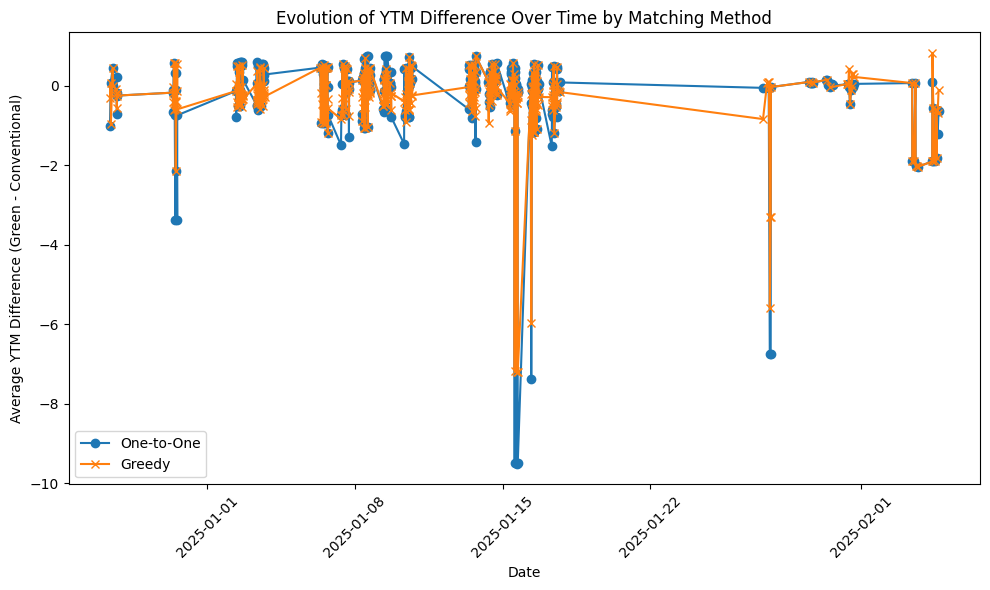

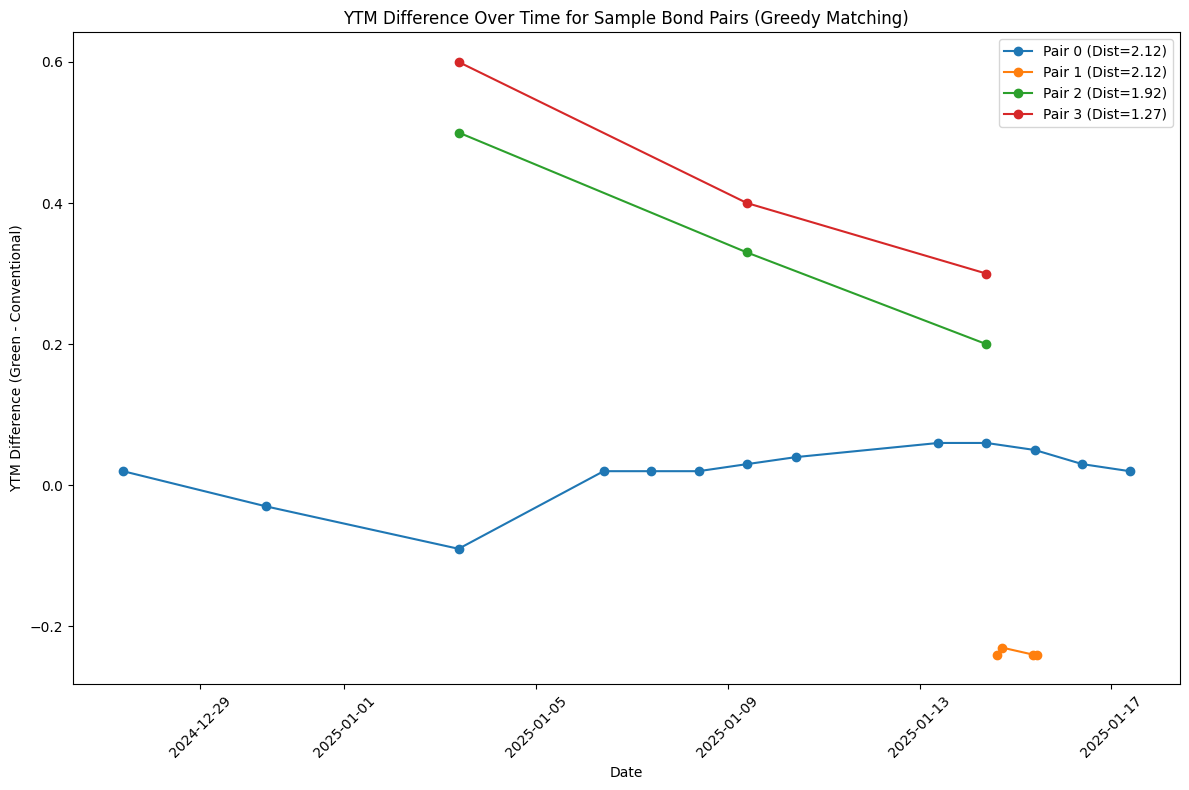

In [66]:
# Time Series Plot: Daily Average YTM Difference for both matching methods
agg_by_date_one2one = regression_ts_one2one.groupby('DateTime').agg({'YTM_diff': 'mean'}).reset_index()
agg_by_date_greedy = regression_ts_greedy.groupby('DateTime').agg({'YTM_diff': 'mean'}).reset_index()

plt.figure(figsize=(10, 6))
plt.plot(agg_by_date_one2one['DateTime'], agg_by_date_one2one['YTM_diff'], marker='o', label='One-to-One')
plt.plot(agg_by_date_greedy['DateTime'], agg_by_date_greedy['YTM_diff'], marker='x', label='Greedy')
plt.xlabel('Date')
plt.ylabel('Average YTM Difference (Green - Conventional)')
plt.title('Evolution of YTM Difference Over Time by Matching Method')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Additional Plot: YTM Difference over time for a few bond pairs (Greedy Matching)
sample_pairs = regression_ts_greedy['Bond_Pair_ID'].unique()[:4]
plt.figure(figsize=(12, 8))
for pair in sample_pairs:
    pair_data = regression_ts_greedy[regression_ts_greedy['Bond_Pair_ID'] == pair]
    plt.plot(pair_data['DateTime'], pair_data['YTM_diff'], marker='o', label=f'Pair {pair} (Dist={pair_data["Distance"].iloc[0]:.2f})')
plt.xlabel('Date')
plt.ylabel('YTM Difference (Green - Conventional)')
plt.title('YTM Difference Over Time for Sample Bond Pairs (Greedy Matching)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()